# Extraer espetrogramas

In [34]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import GradScaler, autocast
from itertools import cycle
from PIL import Image
import math
from IPython.display import display
from tqdm import tqdm
import cv2
import librosa
from torchvision import transforms, datasets, utils
from typing import Tuple
from torchvision import models

In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Defining the Hyper-parameters**

We now define the hyperparameters that are going to be used throughout the notebook to define the network.


In [36]:

# Hyperparameters
hparams = {
    'batch_size': 1,
    'num_epochs': 10,
    'learning_rate': 0.00005,
    'betas': (0.5, 0.999),
    'num_val_samples': 4,
    'input_channels': 4,
    'output_channels': 3,
    'use_generated_frames_prob': 1
}

### Dataset and Data Loader


In [37]:
import os
from torch.utils.data import Dataset, DataLoader

# Change directory to the folder containing the videos
os.chdir(r'C:/Users/David/Documents/postgrau/Projecte/raining')

# Get a list of all .mp4 files in the folder
video_files = [f for f in os.listdir('.') if f.endswith('.mp4')]

# Create the 'frames' directory if it doesn't exist
if not os.path.exists('frames'):
    os.makedirs('frames')

# Loop through each video file
for video_file in video_files:
    # Load the video
    cap = cv2.VideoCapture(video_file)

    # Initialize frame and spectrogram lists
    frames = []
    spectrograms = []

    # Get the total duration of the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_duration = total_frames / fps

    # Extract frames and spectrograms
    frame_time = 0  # initialize frame time to 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Resize frame to 128x128
        frame = cv2.resize(frame, (256, 256))

        # Extract audio and convert to spectrogram
        # Load a short segment of audio centered around the current frame

        # Pad the audio appropriately for the first and last frames
        if frame_time < 0.5:
            # For the first frames, load audio from the start and pad the beginning
            padding_duration = 0.5 - frame_time
            y, sr = librosa.load(video_file, sr=None, offset=0, duration=frame_time + 0.5)
            y_padded = np.pad(y, (int(sr * padding_duration), 0), 'constant')
        elif frame_time > total_duration - 0.5:
            # For the last frames, load audio from the end and pad the end
            padding_duration = 0.5 - (total_duration - frame_time)
            audio_offset = frame_time - 0.5
            y, sr = librosa.load(video_file, sr=None, offset=audio_offset, duration=1 - padding_duration)
            y_padded = np.pad(y, (0, int(sr * padding_duration)), 'constant')
        else:
            # For all other frames, load 1 second of audio as before
            y, sr = librosa.load(video_file, sr=None, offset=frame_time - 0.5, duration=1)
            y_padded = y

        win_length = 256  # window length in samples
        hop_length = 64  # hop length in samples
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y_padded, win_length=win_length, hop_length=hop_length)), ref=np.max)

        # Resize spectrogram to 128x128
        D = cv2.resize(D, (256, 256))

        spectrograms.append(D)

        # Save frame and spectrogram to the 'frames' directory using the frame time as the filename
        frame_filename = 'frames/{}_{:.3f}_frame.npy'.format(video_file.split('.')[0], frame_time)
        spectrogram_filename = 'frames/{}_{:.3f}_spectrogram.npy'.format(video_file.split('.')[0], frame_time)
        np.save(frame_filename, frame)
        np.save(spectrogram_filename, spectrograms[-1])

        print(f'Saved {frame_filename} and {spectrogram_filename}')

        frames.append(frame)
        frame_time += 1 / fps  # increment frame time by the duration of one frame

    cap.release()

# Ensure the 'results' directory exists
os.makedirs('results', exist_ok=True)





In [38]:
# Change directory to the folder containing the frames and spectrograms
os.chdir('C:/Users/David/Documents/postgrau/Projecte/raining/frames')

import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms


# Custom transformations
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

class TimeMasking(object):
    def __init__(self, max_mask_size):
        self.max_mask_size = max_mask_size

    def __call__(self, tensor):
        time_mask_size = np.random.randint(0, self.max_mask_size)
        time_mask_start = np.random.randint(0, tensor.size(2) - time_mask_size)
        tensor[:, :, time_mask_start:time_mask_start + time_mask_size] = 0
        return tensor

class FrequencyMasking(object):
    def __init__(self, max_mask_size):
        self.max_mask_size = max_mask_size

    def __call__(self, tensor):
        freq_mask_size = np.random.randint(0, self.max_mask_size)
        freq_mask_start = np.random.randint(0, tensor.size(1) - freq_mask_size)
        tensor[:, freq_mask_start:freq_mask_start + freq_mask_size, :] = 0
        return tensor

# Dataset class
class FrameSpectrogramDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.frame_files = sorted([f for f in os.listdir(root_dir) if '_pose' in f and os.path.isfile(os.path.join(root_dir, f))])
        
        # Define the transformations
        self.transformS = transforms.Compose([
            transforms.Resize((256, 256)),  # Resize spectrogram to 256x256
            transforms.RandomApply([AddGaussianNoise(0., 2)], p=0.3),
            transforms.RandomApply([transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0))], p=0.5),
            transforms.RandomApply([FrequencyMasking(max_mask_size=5)], p=0.2),
        ])

        self.transformF = transforms.Compose([
            transforms.Resize((256, 256)),  # Resize frame to 256x256
            transforms.RandomApply([AddGaussianNoise(0., 1)], p=0.5),
            transforms.RandomApply([transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0))], p=0.5),
            transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.5)
        ])
        self.transformF2 = transforms.Compose([
            transforms.Resize((256, 256)),  # Resize frame to 256x256
        ])

    def __len__(self):
        return len(self.frame_files)

    def __getitem__(self, idx):
        frame_file = self.frame_files[idx]
        frame_path = os.path.join(self.root_dir, frame_file)
        
        frame = np.load(frame_path)
        spectrogram_file = frame_file.replace('_pose', '_spectrogram')
        spectrogram_path = os.path.join(self.root_dir, spectrogram_file)
        spectrogram = np.load(spectrogram_path)

        # Get the previous frame
        if idx > 0:
            prev_frame_file = self.frame_files[idx - 1]
            prev_frame_path = os.path.join(self.root_dir, prev_frame_file)
            prev_frame = np.load(prev_frame_path)
        else:
            prev_frame = np.zeros_like(frame)  # Use a zero array if there is no previous frame

        # Convert numpy arrays to PyTorch tensors with the same data type
        frame = torch.from_numpy(frame.astype(np.float32)).permute(2, 0, 1)
        prev_frame = torch.from_numpy(prev_frame.astype(np.float32)).permute(2, 0, 1)
        spectrogram = torch.from_numpy(spectrogram.astype(np.float32)).unsqueeze(0)  # Add channel dimension

        # Apply transformations
        frame = self.transformF2(frame)  # Resize spectrogram to 256x256
        prev_frame = self.transformF(prev_frame)
        spectrogram = self.transformS(spectrogram)

        # Normalize to [-1, 1]
        frame = (frame / 127.5) - 1
        prev_frame = (prev_frame / 127.5) - 1
        spectrogram = (spectrogram / 127.5) - 1

        return frame, prev_frame, spectrogram

# Initialize dataset and dataloaders
dataset = FrameSpectrogramDataset('.')
dataset_size = len(dataset)
split_index = int(0.9 * dataset_size)
train_indices = list(range(split_index))
val_indices = list(range(split_index, dataset_size))
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)  # Assuming hparams['batch_size'] is 16
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [39]:
dataset = FrameSpectrogramDataset('.')
print(len(dataset))

1538


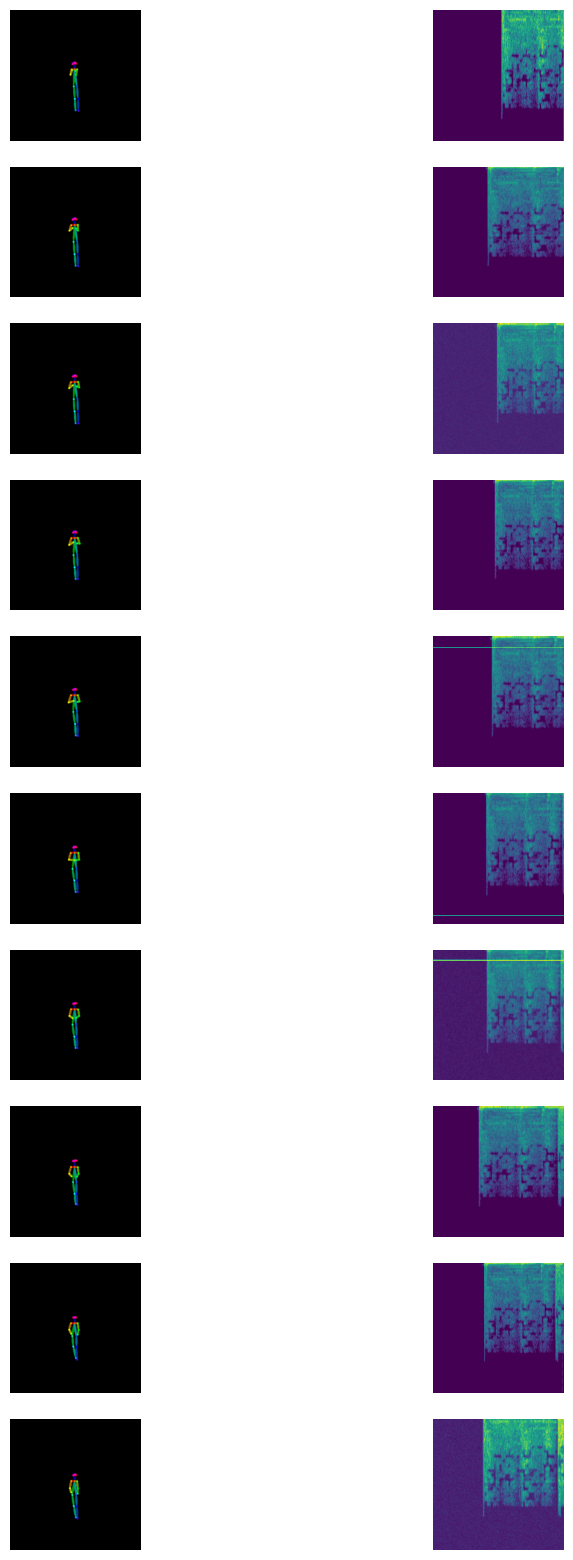

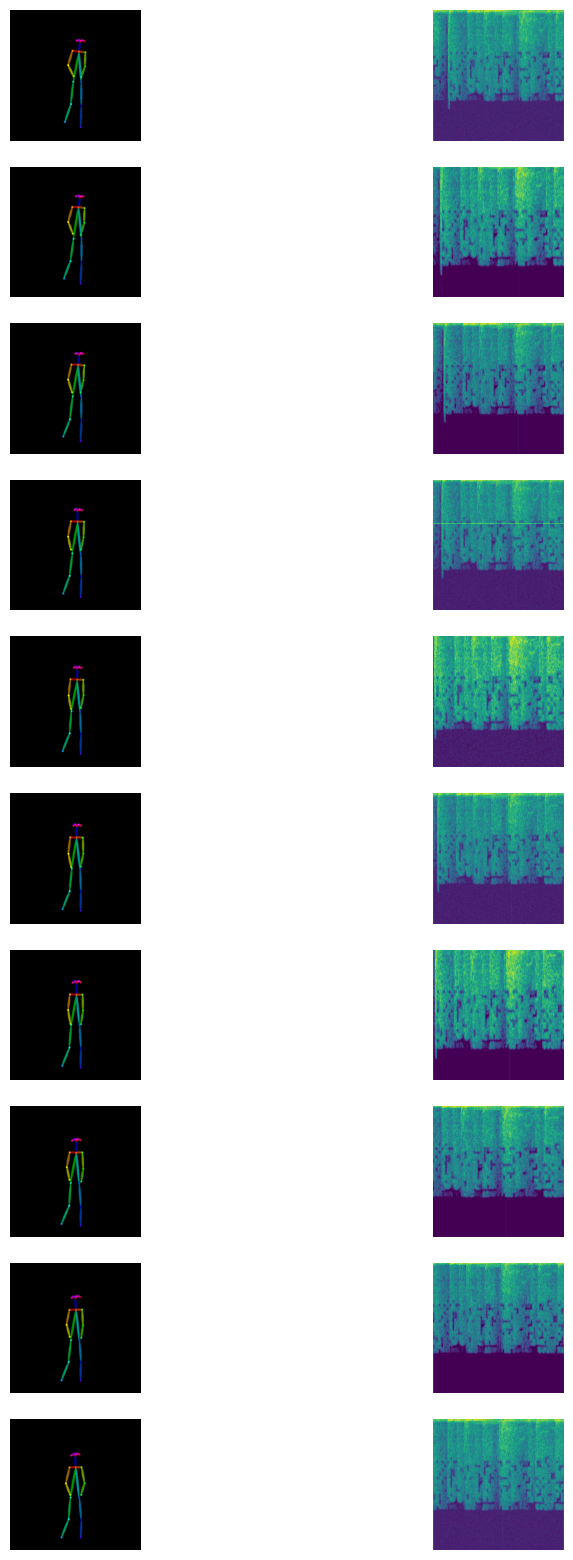

In [40]:
import matplotlib.pyplot as plt

# Function to denormalize images
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Denormalize from [-1, 1] to [0, 1]
    return tensor

# Get the first 10 pairs of data from the dataset
first_10_pairs = [dataset[i] for i in range(10)]

# Get the last 10 pairs of data from the dataset
last_10_pairs = [dataset[i] for i in range(len(dataset) - 10, len(dataset))]

# Plot the first 10 pairs of data
fig, axs = plt.subplots(10, 2, figsize=(10, 20))
for i, (frame, prev_frame, spectrogram) in enumerate(first_10_pairs):
    frame = denormalize(frame.permute(1, 2, 0).numpy())  # Denormalize and rearrange dimensions
    spectrogram = denormalize(spectrogram.permute(1, 2, 0).numpy())  # Denormalize

    axs[i, 0].imshow(frame)
    axs[i, 1].imshow(spectrogram, cmap='viridis')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

plt.show()

# Plot the last 10 pairs of data
fig, axs = plt.subplots(10, 2, figsize=(10, 20))
for i, (frame, prev_frame, spectrogram) in enumerate(last_10_pairs):
    frame = denormalize(frame.permute(1, 2, 0).numpy())  # Denormalize and rearrange dimensions
    spectrogram = denormalize(spectrogram.permute(1, 2, 0).numpy())  # Denormalize

    axs[i, 0].imshow(frame)
    axs[i, 1].imshow(spectrogram, cmap='viridis')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

plt.show()

GAN

In [41]:
# Spectral Normalization Layer
class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = self._l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = self._l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _l2normalize(self, v, eps=1e-12):
        return v / (v.norm() + eps)

    def _made_params(self):
        try:
            getattr(self.module, self.name + "_u")
            getattr(self.module, self.name + "_v")
            getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False

    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = nn.Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = nn.Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = self._l2normalize(u.data)
        v.data = self._l2normalize(v.data)
        w_bar = nn.Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)

    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

In [42]:
# Model definitions
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        self.kernel_size = kernel_size
        
        padding_h = kernel_size[0] // 2
        padding_w = kernel_size[1] // 2
        self.padding = (padding_h, padding_w)
        self.bias = bias
        
        self.conv_i = nn.Conv2d(in_channels=input_dim*2 + hidden_dim, out_channels=hidden_dim, kernel_size=self.kernel_size, padding=self.padding, bias=bias)
        self.conv_f = nn.Conv2d(in_channels=input_dim*2 + hidden_dim, out_channels=hidden_dim, kernel_size=self.kernel_size, padding=self.padding, bias=bias)
        self.conv_c = nn.Conv2d(in_channels=input_dim*2 + hidden_dim, out_channels=hidden_dim, kernel_size=self.kernel_size, padding=self.padding, bias=bias)
        self.conv_o = nn.Conv2d(in_channels=input_dim*2 + hidden_dim, out_channels=hidden_dim, kernel_size=self.kernel_size, padding=self.padding, bias=bias)

    def forward(self, x, h, c):
        combined = torch.cat((x, h), dim=1)
        i = torch.sigmoid(self.conv_i(combined))
        f = torch.sigmoid(self.conv_f(combined))
        c = f * c + i * torch.tanh(self.conv_c(combined))
        o = torch.sigmoid(self.conv_o(combined))
        h = o * torch.tanh(c)
        return h, c

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv_i.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv_i.weight.device))



    def apply_weights_init(self):
        self.conv.apply(weights_init_normal)

In [43]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(query, key)
        attention = F.softmax(energy, dim=-1)
        value = self.value_conv(x).view(batch_size, -1, width * height)

        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)
        out = self.gamma * out + x

        return out

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

In [44]:
class SpectrogramProcessor(nn.Module):
    def __init__(self, input_channels=1, hidden_dim=512):
        super(SpectrogramProcessor, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)

        def down_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, dilation=1, batch_norm=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation=dilation, bias=False)]
            if batch_norm:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)
        
        self.down2 = down_block(64, 200, kernel_size=3, dilation=2, padding=2)  # Adjusted kernel size and padding
        self.down3 = down_block(200, 512, kernel_size=3, dilation=4, padding=4)  # Adjusted kernel size and padding
        self.down4 = down_block(512, 512, kernel_size=3, dilation=8, padding=8)  # Adjusted kernel size and padding
        self.down5 = down_block(512, 512, kernel_size=3, dilation=16, padding=16)  # Adjusted kernel size and padding
        self.down6 = down_block(512, 512, kernel_size=3, dilation=32, padding=32)  # Adjusted kernel size and padding
        self.down7 = down_block(512, 512, kernel_size=3, dilation=64, padding=64)  # Adjusted kernel size and padding
        self.down8 = down_block(512, 512, kernel_size=3, dilation=128, padding=128)  # Adjusted kernel size and padding
        self.down9 = down_block(512, 512, kernel_size=3, dilation=256, batch_norm=False, padding=256)  # Adjusted kernel size and padding

        self.spatial_attention1 = SpatialAttention()
        self.spatial_attention2 = SpatialAttention()
        self.self_attention1 = SelfAttention(512)
        self.self_attention2 = SelfAttention(512)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.down2(x)
        x = self.down3(x)
        x = self.down4(x)
        x = self.down5(x)
        x = self.down6(x)
        x = self.down7(x)
        x = self.down8(x)
        x = self.down9(x)
        x = self.self_attention1(x)
        x = self.self_attention2(x)
        
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out


In [45]:
class UNetGenerator(nn.Module):
    def __init__(self, input_channels=4, output_channels=3, hidden_channels=512, lstm_kernel_size=3):
        super(UNetGenerator, self).__init__()

        def down_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        def up_block(in_channels, out_channels, dropout=0.0):
            layers = [nn.Conv2d(in_channels, out_channels * 4, kernel_size=3, stride=1, padding=1, bias=False),
                      nn.PixelShuffle(2)]
            layers.append(nn.BatchNorm2d(out_channels))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            layers.append(nn.ReLU(inplace=True))
            return nn.Sequential(*layers)

        self.spectrogram_processor = SpectrogramProcessor(input_channels=1, hidden_dim=hidden_channels)

        self.down1 = down_block(3, 64, batch_norm=False)
        self.down2 = down_block(64, 128)
        self.down3 = down_block(128, 256)
        self.down4 = down_block(256, 512)
        self.down5 = down_block(512, 512)
        self.down6 = down_block(512, 512)
        self.down7 = down_block(512, 512)
        self.down8 = down_block(512, 512, batch_norm=False)

        self.convlstm = ConvLSTMCell(512, hidden_channels, lstm_kernel_size)

        self.up1 = up_block(hidden_channels, 512, dropout=0.5)
        self.up2 = up_block(1024, 512, dropout=0.5)
        self.up3 = up_block(1024, 512, dropout=0.5)
        self.up4 = up_block(1024, 512)
        self.up5 = up_block(1024, 256)
        self.up6 = up_block(512, 128)
        self.up7 = up_block(256, 64)
        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(128, output_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

        self.self_attention1 = SelfAttention(512)
        self.self_attention2 = SelfAttention(512)
        self.self_attention3 = SelfAttention(512)
        
        self.spatial_attention1 = SpatialAttention()
        self.spatial_attention2 = SpatialAttention()
        self.spatial_attention3 = SpatialAttention()

        # Residual Blocks
        self.residual1 = ResidualBlock(64, 64)
        self.residual2 = ResidualBlock(128, 128)
        self.residual3 = ResidualBlock(256, 256)
        self.residual4 = ResidualBlock(512, 512)
        self.residual5 = ResidualBlock(512, 512)
        self.residual6 = ResidualBlock(512, 512)
        self.residual7 = ResidualBlock(512, 512)

        # Dilated Convolution Blocks
        self.dilated1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, dilation=1)
        self.dilated2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=2, dilation=2)
        self.dilated3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=4, dilation=4)
        self.dilated4 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=8, dilation=8)
        self.dilated5 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=16, dilation=16)

    def forward(self, x, hidden_state=None):
        spectrogram = x[:, 0:1, :, :]
        frame = x[:, 1:4, :, :]

        d1 = self.residual1(self.down1(frame))
        d2 = self.residual2(self.down2(d1))
        d3 = self.residual3(self.down3(d2))
        d4 = self.residual4(self.down4(d3))
        d5 = self.residual5(self.down5(d4))
        d6 = self.residual6(self.down6(d5))
        d7 = self.residual7(self.down7(d6))
        d8 = self.down8(d7)

        spectrogram_features = self.spectrogram_processor(spectrogram)

        combined_features = torch.cat([d8, spectrogram_features], dim=1)

        if hidden_state is None:
            h, c = self.convlstm.init_hidden(x.size(0), (combined_features.size(2), combined_features.size(3)))
            h, c = self.convlstm(combined_features, h, c)  # Pass hidden_state as separate arguments
        else:
            h, c = hidden_state  # Use the provided hidden state
            h, c = self.convlstm(combined_features, h, c)

        u1 = self.up1(h)

        # Apply spatial attention
        u1 = u1 * self.spatial_attention1(u1)
        u1 = u1 * self.spatial_attention2(u1)
        u1 = u1 * self.spatial_attention3(u1)

        u2 = self.up2(torch.cat([u1, self.self_attention1(d7)], 1))
        u3 = self.up3(torch.cat([u2, self.self_attention2(d6)], 1))
        u4 = self.up4(torch.cat([u3, self.self_attention3(d5)], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        u8 = self.up8(torch.cat([u7, d1], 1))

        return u8, (h, c)

# Properly initialize the weights
def weights_init_normal(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and isinstance(m.weight, torch.Tensor):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if hasattr(m, 'bias') and isinstance(m.bias, torch.Tensor):
        nn.init.constant_(m.bias.data, 0)
    if classname.find('InstanceNorm') != -1 and hasattr(m, 'weight') and isinstance(m.weight, torch.Tensor):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        if hasattr(m, 'bias') and isinstance(m.bias, torch.Tensor):
            nn.init.constant_(m.bias.data, 0)



In [46]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self, input_channels=7):
        super(PatchGANDiscriminator, self).__init__()
        
        def disc_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)]
            if batch_norm:
                layers.append(nn.InstanceNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)
        
        self.model = nn.Sequential(
            disc_block(input_channels, 64, batch_norm=False),  # First layer should match input_channels
            disc_block(64, 128),
            disc_block(128, 256),
            disc_block(256, 512),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

In [47]:
class MultiScaleDiscriminator(nn.Module):
    def __init__(self, input_channels=7):
        super(MultiScaleDiscriminator, self).__init__()
        self.disc1 = PatchGANDiscriminator(input_channels)
        self.disc2 = PatchGANDiscriminator(input_channels)
    
    def forward(self, x):
        #print("Size of input to discriminator:", x.size())  # Add this line for debugging
        #print("Datatype of input to discriminator:", x.dtype)  # Add this line for debugging
        x1 = self.disc1(x)
        #print("Size of output from disc1:", x1.size())  # Add this line for debugging
        #print("Datatype of output from disc1:", x1.dtype)  # Add this line for debugging
        x2 = self.disc2(F.avg_pool2d(x, 3, stride=2, padding=[1,1]))
        return [x1, x2]

In [48]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = [torch.ones_like(d_interpolate, device=device) for d_interpolate in d_interpolates]
    gradients = []
    for d_interpolate, f in zip(d_interpolates, fake):
        gradient = torch.autograd.grad(
            outputs=d_interpolate, inputs=interpolates,
            grad_outputs=f, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        gradients.append(gradient.view(gradient.size(0), -1))
    gradient_penalty = sum(((gradient.norm(2, dim=1) - 1) ** 2).mean() for gradient in gradients)
    return gradient_penalty

class FeatureMatchingLoss(nn.Module):
    def __init__(self, D):
        super(FeatureMatchingLoss, self).__init__()
        self.D = D

    def forward(self, real, fake):
        #print("Size of real before D:", real.size())
        #print("Datatype of real before D:", real.dtype)
        #print("Size of fake before D:", fake.size())
        #print("Datatype of fake before D:", fake.dtype)

        real_features = self.D(real)
        fake_features = self.D(fake)

        loss = 0
        for real_feat, fake_feat in zip(real_features, fake_features):
            loss += torch.nn.functional.l1_loss(fake_feat, real_feat)
        return loss

In [49]:
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features
        self.layers = nn.Sequential(*list(vgg[:36])).eval()
        for param in self.layers.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        input_features = self.layers(input)
        target_features = self.layers(target)
        return nn.functional.mse_loss(input_features, target_features)

In [50]:
# Initialize models, optimizers, and criteria
netG = UNetGenerator().to(device)
netD = MultiScaleDiscriminator(input_channels=hparams['input_channels'] + hparams['output_channels']).to(device)

netG.apply(weights_init_normal)
netD.apply(weights_init_normal)

optimizerG = optim.Adam(netG.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])
optimizerD = optim.Adam(netD.parameters(), lr=hparams['learning_rate'], betas=hparams['betas'])

schedulerG = StepLR(optimizerG, step_size=10, gamma=0.1)
schedulerD = StepLR(optimizerD, step_size=10, gamma=0.1)

criterion_gan = nn.BCEWithLogitsLoss().to(device)
criterion_l1 = nn.L1Loss()
criterion_perceptual = PerceptualLoss().to(device)
feature_matching_loss = FeatureMatchingLoss(netD).to(device)

In [51]:
hparams = {
    'batch_size': 1,
    'learning_rate': 0.00005,
    'betas': (0.5, 0.999),
    'num_epochs': 15,
    'num_val_samples': 4,
    'input_channels': 4,
    'output_channels': 3,
    'use_generated_frames_prob': 1
}

Train

Epoch [0/15], Step [0/1384], Loss D: 2500.9836, Loss G: 59.0459
Validation Loss G: 59.6031
Epoch [0/15], Step [400/1384], Loss D: 1.3881, Loss G: 8.6716
Validation Loss G: 12.0522
Epoch [0/15], Step [800/1384], Loss D: 1.4155, Loss G: 7.5689
Validation Loss G: 11.7892
Epoch [0/15], Step [1200/1384], Loss D: 1.3272, Loss G: 13.3864
Validation Loss G: 12.2884


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


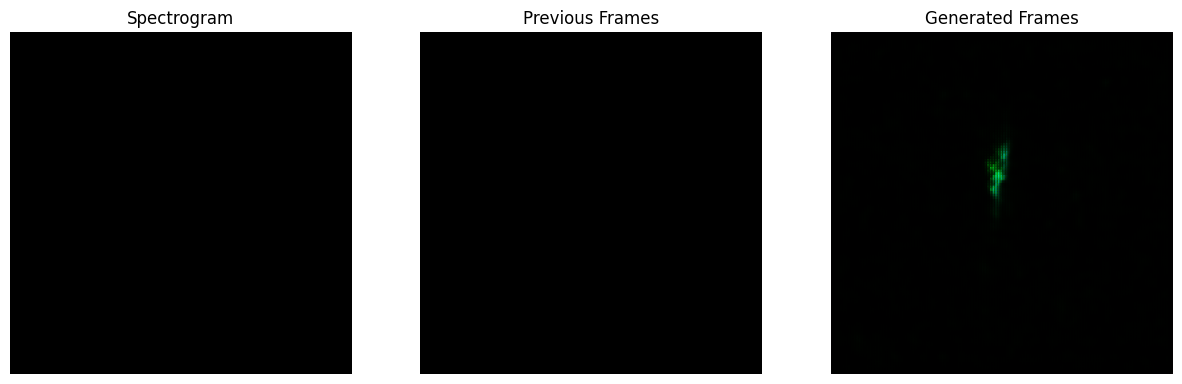

Epoch [1/15], Step [0/1384], Loss D: 1.3842, Loss G: 12.0072
Validation Loss G: 11.7735
Epoch [1/15], Step [400/1384], Loss D: 1.4845, Loss G: 10.1098
Validation Loss G: 11.6522
Epoch [1/15], Step [800/1384], Loss D: 1.4103, Loss G: 7.1885
Validation Loss G: 10.3023
Epoch [1/15], Step [1200/1384], Loss D: 1.3697, Loss G: 10.8183
Validation Loss G: 11.0928
NaN detected in lossD_real
NaN detected in lossD_fake
NaN detected in gradient_penalty


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


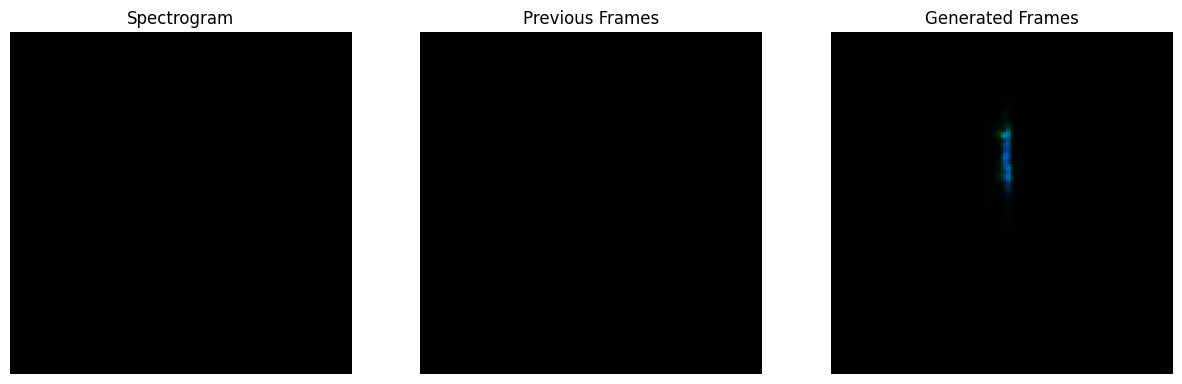

Epoch [2/15], Step [0/1384], Loss D: 1.3481, Loss G: 11.3058
Validation Loss G: 10.8037
Epoch [2/15], Step [400/1384], Loss D: 1.4038, Loss G: 9.9558
Validation Loss G: 10.6818
Epoch [2/15], Step [800/1384], Loss D: 1.4146, Loss G: 6.9570
Validation Loss G: 11.1207
Epoch [2/15], Step [1200/1384], Loss D: 1.5239, Loss G: 8.2226
Validation Loss G: 9.2795
NaN detected in lossD_real
NaN detected in lossD_fake
NaN detected in gradient_penalty


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


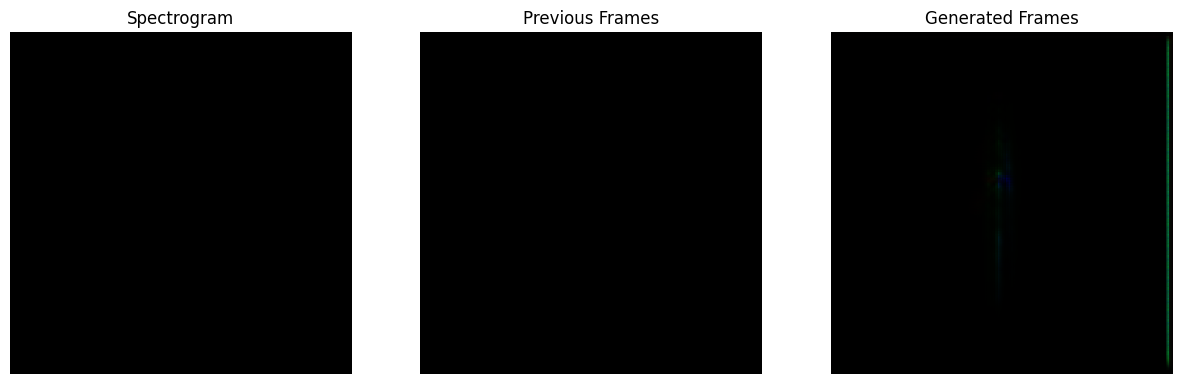

Epoch [3/15], Step [0/1384], Loss D: 1.3632, Loss G: 10.3157
Validation Loss G: 10.0636
Epoch [3/15], Step [400/1384], Loss D: 1.3852, Loss G: 8.5033
Validation Loss G: 11.3902
Epoch [3/15], Step [800/1384], Loss D: 1.3986, Loss G: 7.2913
Validation Loss G: 9.6495
Epoch [3/15], Step [1200/1384], Loss D: 1.4210, Loss G: 8.2618
Validation Loss G: 9.4047


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


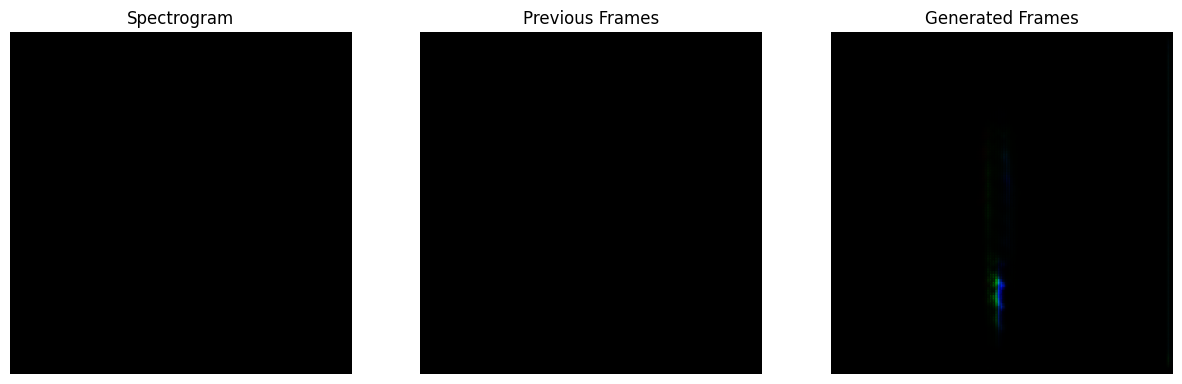

Epoch [4/15], Step [0/1384], Loss D: 1.4706, Loss G: 10.0052
Validation Loss G: 9.6819
Epoch [4/15], Step [400/1384], Loss D: 1.3677, Loss G: 9.3020
Validation Loss G: 11.0397
Epoch [4/15], Step [800/1384], Loss D: 1.3824, Loss G: 8.3616
Validation Loss G: 10.8213
Epoch [4/15], Step [1200/1384], Loss D: 1.3587, Loss G: 12.1345
Validation Loss G: 11.9532


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


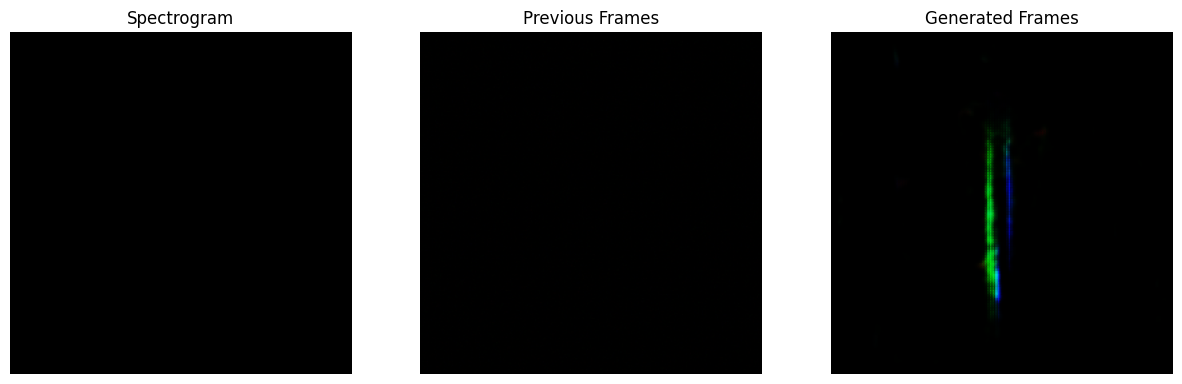

Epoch [5/15], Step [0/1384], Loss D: 1.4003, Loss G: 9.4881
Validation Loss G: 9.9531
Epoch [5/15], Step [400/1384], Loss D: 1.3945, Loss G: 7.3361
Validation Loss G: 9.6694
Epoch [5/15], Step [800/1384], Loss D: 1.3964, Loss G: 8.2559
Validation Loss G: 10.5550
Epoch [5/15], Step [1200/1384], Loss D: 1.4128, Loss G: 7.9815
Validation Loss G: 9.6959


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


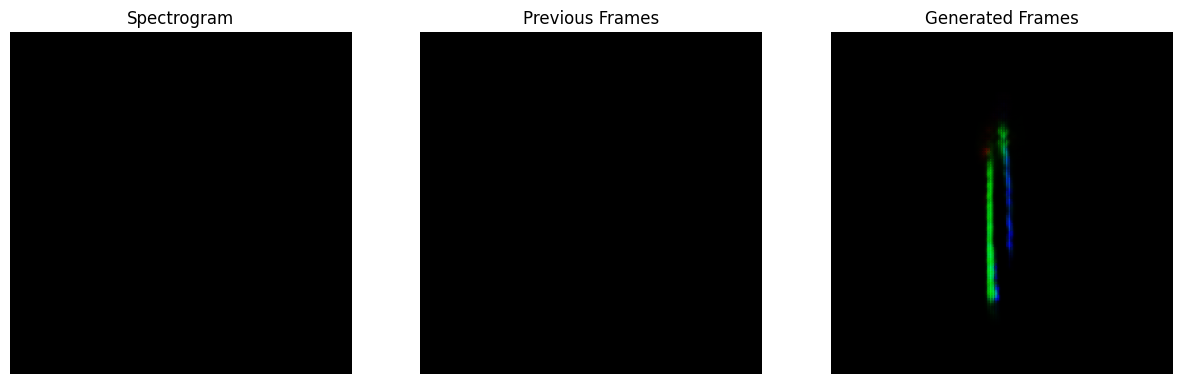

Epoch [6/15], Step [0/1384], Loss D: 1.4300, Loss G: 9.8522
Validation Loss G: 9.7829
Epoch [6/15], Step [400/1384], Loss D: 1.3663, Loss G: 9.1299
Validation Loss G: 11.1246
Epoch [6/15], Step [800/1384], Loss D: 1.3968, Loss G: 7.3356
Validation Loss G: 9.6605
Epoch [6/15], Step [1200/1384], Loss D: 1.3742, Loss G: 10.6997
Validation Loss G: 9.5246


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


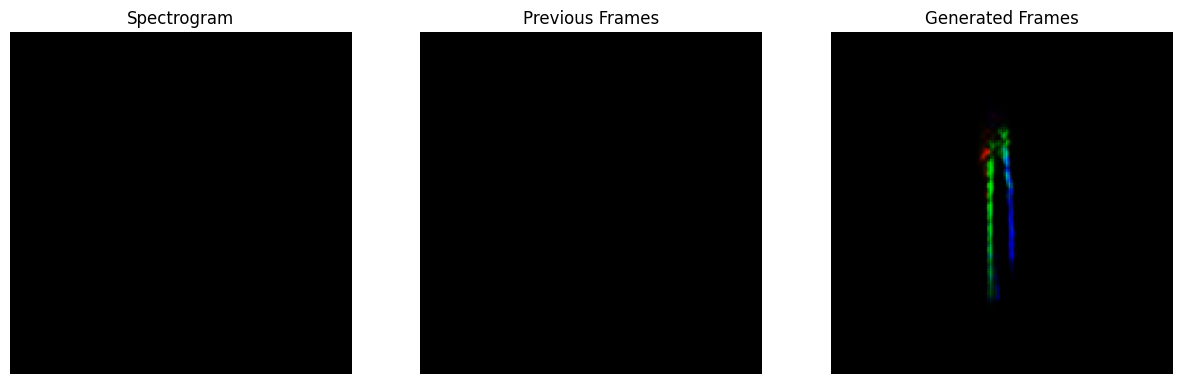

Epoch [7/15], Step [0/1384], Loss D: 1.3877, Loss G: 9.2839
Validation Loss G: 9.6129
Epoch [7/15], Step [400/1384], Loss D: 1.3751, Loss G: 9.6221
Validation Loss G: 10.6906
Epoch [7/15], Step [800/1384], Loss D: 1.4093, Loss G: 7.6617
Validation Loss G: 9.7004
Epoch [7/15], Step [1200/1384], Loss D: 1.3916, Loss G: 8.2062
Validation Loss G: 9.5801


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


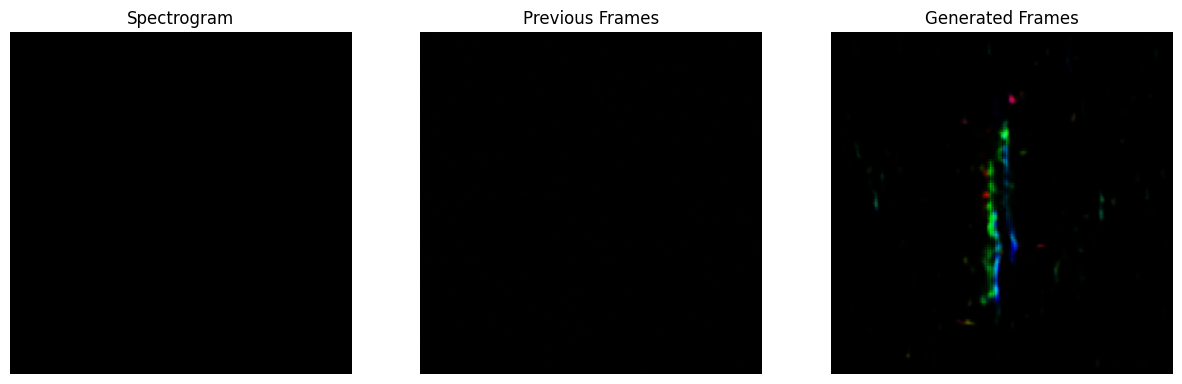

Epoch [8/15], Step [0/1384], Loss D: 1.3830, Loss G: 9.6984
Validation Loss G: 9.5972
Epoch [8/15], Step [400/1384], Loss D: 1.3989, Loss G: 6.9147
Validation Loss G: 10.5884
Epoch [8/15], Step [800/1384], Loss D: 1.3867, Loss G: 7.6243
Validation Loss G: 9.8926
Epoch [8/15], Step [1200/1384], Loss D: 1.3804, Loss G: 9.9083
Validation Loss G: 9.8008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


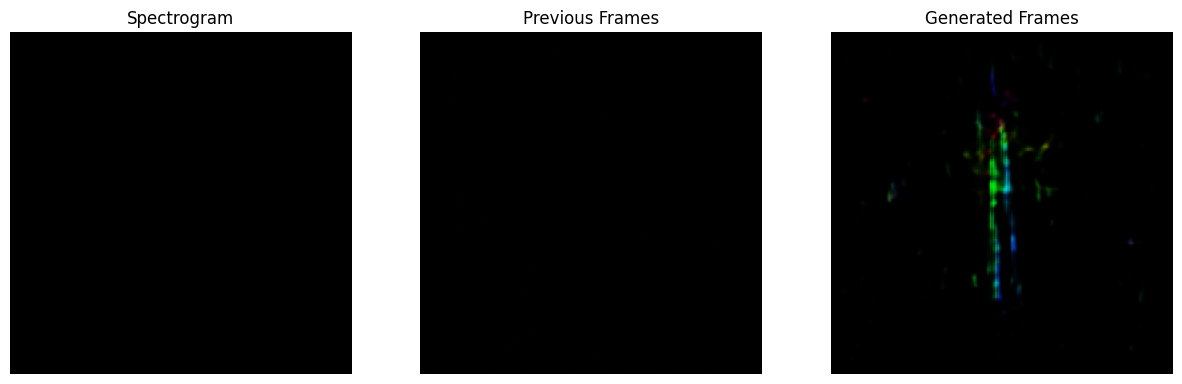

Epoch [9/15], Step [0/1384], Loss D: 1.3813, Loss G: 9.2654
Validation Loss G: 9.7946
Epoch [9/15], Step [400/1384], Loss D: 1.3920, Loss G: 8.1647
Validation Loss G: 9.9708
Epoch [9/15], Step [800/1384], Loss D: 1.3875, Loss G: 7.5661
Validation Loss G: 9.7193
Epoch [9/15], Step [1200/1384], Loss D: 1.4029, Loss G: 7.8062
Validation Loss G: 9.8661


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


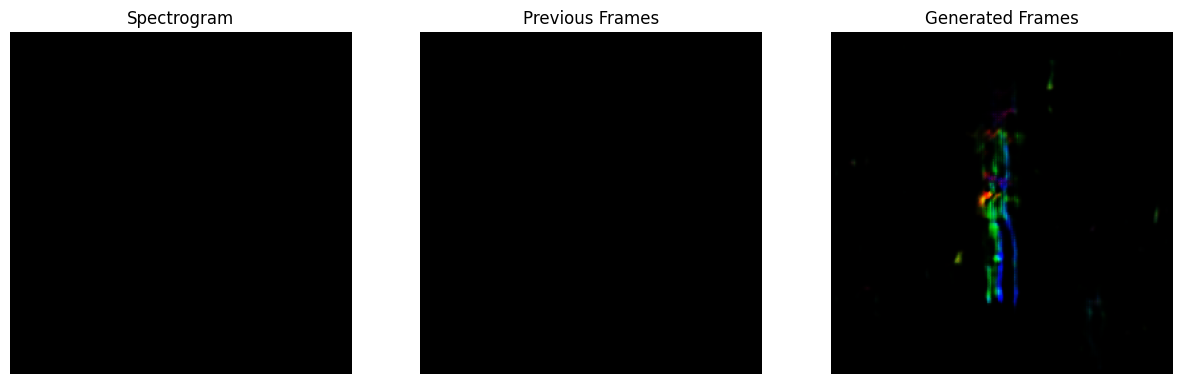

Epoch [10/15], Step [0/1384], Loss D: 1.4023, Loss G: 9.3810
Validation Loss G: 9.5776
Epoch [10/15], Step [400/1384], Loss D: 1.3889, Loss G: 7.1330
Validation Loss G: 9.5650
NaN detected in lossD_real
NaN detected in lossD_fake
NaN detected in gradient_penalty
Epoch [10/15], Step [800/1384], Loss D: 1.3888, Loss G: 7.2282
Validation Loss G: 9.4452
Epoch [10/15], Step [1200/1384], Loss D: 1.3906, Loss G: 9.2471
Validation Loss G: 9.8277


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


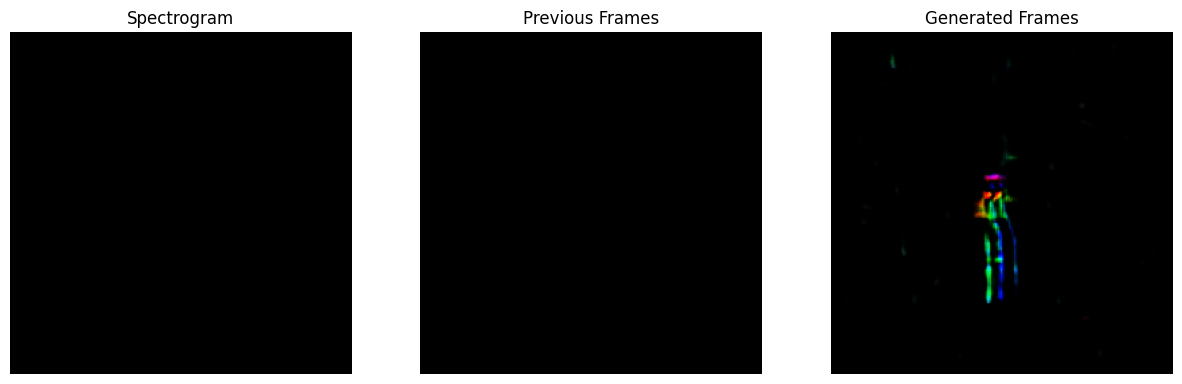

Epoch [11/15], Step [0/1384], Loss D: 1.3917, Loss G: 9.4688
Validation Loss G: 9.4294
Epoch [11/15], Step [400/1384], Loss D: 1.3893, Loss G: 7.1115
Validation Loss G: 9.4505
Epoch [11/15], Step [800/1384], Loss D: 1.3704, Loss G: 8.1762
Validation Loss G: 9.6057
Epoch [11/15], Step [1200/1384], Loss D: 1.3705, Loss G: 9.3264
Validation Loss G: 9.7906


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


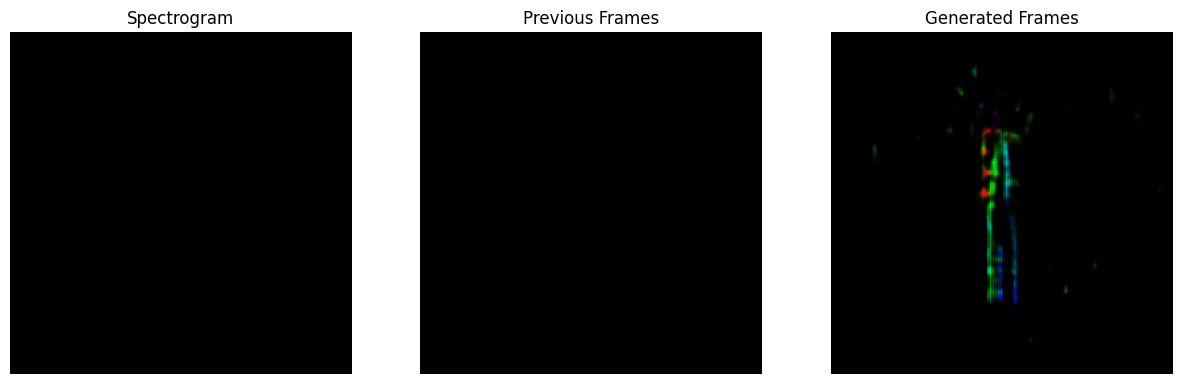

Epoch [12/15], Step [0/1384], Loss D: 1.5487, Loss G: 10.1754
Validation Loss G: 9.5178
Epoch [12/15], Step [400/1384], Loss D: 1.3564, Loss G: 9.1153
Validation Loss G: 10.7839
Epoch [12/15], Step [800/1384], Loss D: 1.3878, Loss G: 8.0812
Validation Loss G: 9.7265
Epoch [12/15], Step [1200/1384], Loss D: 1.3504, Loss G: 11.4279
Validation Loss G: 11.5407


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


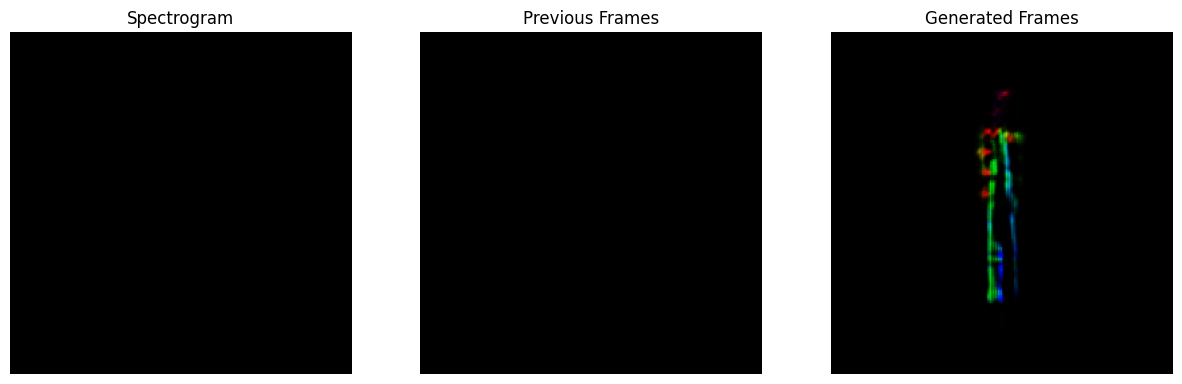

Epoch [13/15], Step [0/1384], Loss D: 1.3833, Loss G: 9.3607
Validation Loss G: 9.3455
Epoch [13/15], Step [400/1384], Loss D: 1.3891, Loss G: 7.1241
Validation Loss G: 9.3944
Epoch [13/15], Step [800/1384], Loss D: 1.3653, Loss G: 8.6912
Validation Loss G: 10.3745
Epoch [13/15], Step [1200/1384], Loss D: 1.3883, Loss G: 7.8025
Validation Loss G: 9.7536


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


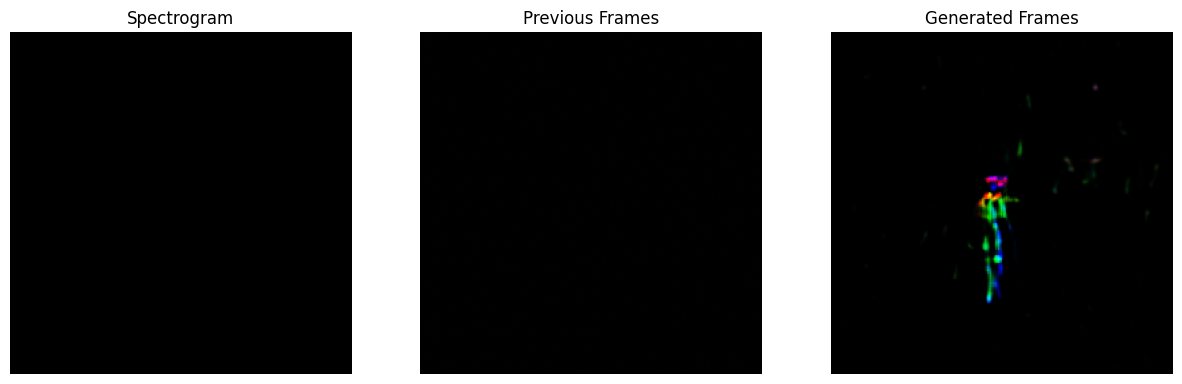

Epoch [14/15], Step [0/1384], Loss D: 1.4307, Loss G: 9.8649
Validation Loss G: 9.3300
Epoch [14/15], Step [400/1384], Loss D: 1.3764, Loss G: 8.0661
Validation Loss G: 10.1614
NaN detected in lossD_real
NaN detected in lossD_fake
NaN detected in gradient_penalty
Epoch [14/15], Step [800/1384], Loss D: 1.3868, Loss G: 7.1830
Validation Loss G: 9.5963
Epoch [14/15], Step [1200/1384], Loss D: 1.3949, Loss G: 7.8730
Validation Loss G: 9.7230


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


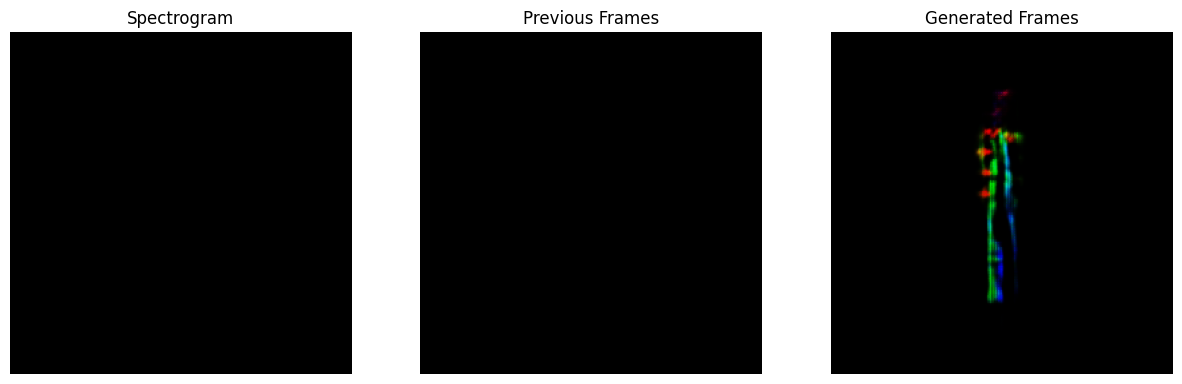

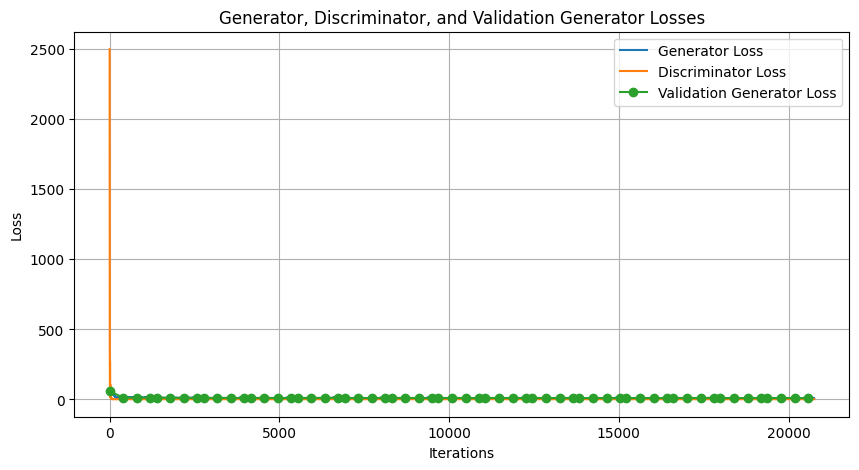

In [52]:
# Function to check for NaNs in a tensor
def check_nan(tensor, name=""):
    if torch.isnan(tensor).any():
        print(f"NaN detected in {name}")
        return True
    return False

# Training loop
netG.train()
losses_G = []
losses_D = []
val_losses_G = []
val_iteration_steps = []

for epoch in range(hparams['num_epochs']):
    for i, (real_frames, prev_frames, spectrograms) in enumerate(dataloader):
        real_frames = real_frames.to(device)
        prev_frames = prev_frames.to(device)
        spectrograms = spectrograms.to(device)

        hidden_state = None
        inputs = torch.cat((spectrograms, prev_frames), dim=1)  # (N, 4, H, W)

        generated_frames = []
        fake_frames, hidden_state = netG(inputs, hidden_state)
        generated_frames.append(fake_frames)
        use_generated = random.random() < hparams['use_generated_frames_prob']
        if use_generated and len(generated_frames) > 1:
            prev_frames = generated_frames[-1]

        inputs = torch.cat((spectrograms, prev_frames), dim=1)
        real_inputs = torch.cat((inputs, real_frames), 1)  # (N, 7, H, W)

        optimizerD.zero_grad()
        # Compute losses for Discriminator D
        output_real = netD(real_inputs)
        real_labels = [torch.ones_like(out).to(device) for out in output_real]
        losses_D_real = [criterion_gan(out, label) for out, label in zip(output_real, real_labels)]
        lossD_real = sum(losses_D_real)

        fake_inputs = torch.cat((inputs, fake_frames.detach()), 1)  # (N, 7, H, W)
        output_fake = netD(fake_inputs)
        fake_labels = [torch.zeros_like(out_fake).to(device) for out_fake in output_fake]
        lossD_fake = sum([criterion_gan(out_fake, fake_label) for out_fake, fake_label in zip(output_fake, fake_labels)])

        gradient_penalty = compute_gradient_penalty(netD, real_inputs.data, fake_inputs.data)

        # Check for NaNs before the backward pass
        if any([check_nan(tensor, name) for tensor, name in zip([lossD_real, lossD_fake, gradient_penalty], ['lossD_real', 'lossD_fake', 'gradient_penalty'])]):
            continue

        lossD = (lossD_real + lossD_fake) * 0.5 + gradient_penalty
        lossD.backward()
        torch.nn.utils.clip_grad_norm_(netD.parameters(), max_norm=1.0)
        optimizerD.step()

        optimizerG.zero_grad()
        # Compute losses and gradients for Generator G
        fake_inputs = torch.cat((inputs, fake_frames), 1)  # (N, 7, H, W)
        output_fake = netD(fake_inputs)
        loss_gan = sum([criterion_gan(out_fake, real_label) for out_fake, real_label in zip(output_fake, real_labels)])
        loss_l1 = criterion_l1(fake_frames, real_frames)
        loss_perceptual = criterion_perceptual(fake_frames, real_frames)
        loss_feature_matching = feature_matching_loss(real_inputs, fake_inputs)

        # Check for NaNs before the backward pass
        if any([check_nan(tensor, name) for tensor, name in zip([loss_gan, loss_l1, loss_perceptual, loss_feature_matching], ['loss_gan', 'loss_l1', 'loss_perceptual', 'loss_feature_matching'])]):
            continue

        lossG = (loss_gan * 5 + loss_l1 * 50 + loss_perceptual * 10 + loss_feature_matching * 10)
        lossG.backward()
        torch.nn.utils.clip_grad_norm_(netG.parameters(), max_norm=1.0)
        optimizerG.step()

        lossG = lossG.to(device)
        lossD = lossD.to(device)
        losses_G.append(lossG.item())
        losses_D.append(lossD.item())

        if i % 400 == 0:
            print(f'Epoch [{epoch}/{hparams["num_epochs"]}], Step [{i}/{len(dataloader)}], '
                f'Loss D: {lossD.item():.4f}, Loss G: {lossG.item():.4f}')
            with torch.no_grad():
                val_lossG = 0.0
                for val_real_frames, val_prev_frames, val_spectrograms in val_loader:
                    val_real_frames = val_real_frames.to(device)
                    val_prev_frames = val_prev_frames.to(device)
                    val_spectrograms = val_spectrograms.to(device)

                    val_inputs = torch.cat((val_spectrograms, val_prev_frames), dim=1)  # (N, 4, H, W)
                    val_fake_frames, _ = netG(val_inputs, hidden_state)

                    val_fake_inputs = torch.cat((val_inputs, val_fake_frames), 1)  # (N, 7, H, W)

                    val_output_fake = netD(val_fake_inputs)
                    real_labels = [torch.ones_like(out).to(device) for out in val_output_fake]

                    losses_val_gan = [criterion_gan(out, label) for out, label in zip(val_output_fake, real_labels)]
                    val_loss_gan = sum(losses_val_gan)
                    val_loss_l1 = criterion_l1(val_fake_frames, val_real_frames)
                    val_loss_perceptual = criterion_perceptual(val_fake_frames, val_real_frames)
                    val_loss_feature_matching = feature_matching_loss(real_inputs, val_fake_inputs)

                    # Check for NaNs before summing the validation loss
                    if any([check_nan(tensor, name) for tensor, name in zip([val_loss_gan, val_loss_l1, val_loss_perceptual, val_loss_feature_matching], ['val_loss_gan', 'val_loss_l1', 'val_loss_perceptual', 'val_loss_feature_matching'])]):
                        continue

                    val_lossG += (val_loss_gan * 5 + val_loss_l1 * 50 + val_loss_perceptual * 10 + val_loss_feature_matching * 10).item()
                    
            val_lossG /= len(val_loader)
            val_losses_G.append(val_lossG)
            val_iteration_steps.append(epoch * len(dataloader) + i)
            print(f'Validation Loss G: {val_lossG:.4f}')
    
    schedulerG.step()
    schedulerD.step()

    # Visualize input and output images
    with torch.no_grad():
        random_batch = next(iter(dataloader))
        prev_frames_batch = random_batch[1][:hparams['num_val_samples']].to(device)
        spectrograms_batch = random_batch[2][:hparams['num_val_samples']].to(device)
        fake_frames_batch, _ = netG(torch.cat((spectrograms_batch, prev_frames_batch), dim=1))

        def denormalize(tensor):
            tensor = tensor * 0.5 + 0.5  # Denormalize from [-1, 1] to [0, 1]
            return tensor

        prev_frames_denorm = denormalize(prev_frames_batch)
        fake_frames_denorm = denormalize(fake_frames_batch)

        spect_grid = make_grid(spectrograms_batch, nrow=hparams['num_val_samples'])
        prev_img_grid = make_grid(prev_frames_denorm, nrow=hparams['num_val_samples'])
        fake_img_grid = make_grid(fake_frames_denorm, nrow=hparams['num_val_samples'])

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title('Spectrogram')
        plt.imshow(spect_grid.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Previous Frames')
        plt.imshow(prev_img_grid.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Generated Frames')
        plt.imshow(fake_img_grid.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')

        plt.show()

plt.figure(figsize=(10, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.plot(val_iteration_steps, val_losses_G, label='Validation Generator Loss', marker='o')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator, Discriminator, and Validation Generator Losses')
plt.legend()
plt.grid(True)
plt.show()

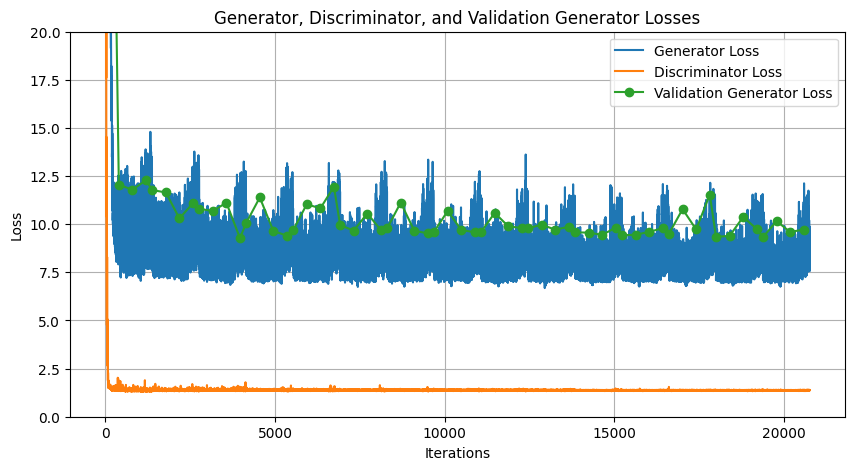

In [53]:
# Plot the losses

plt.figure(figsize=(10, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.plot(val_iteration_steps, val_losses_G, label='Validation Generator Loss', marker='o')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator, Discriminator, and Validation Generator Losses')
plt.legend()
plt.ylim(0, 20)  # Set the y-axis limits
plt.grid(True)
plt.show()

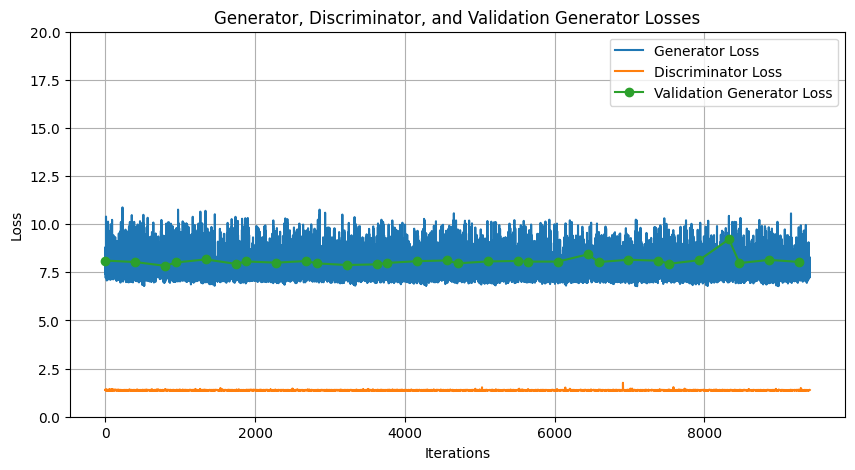

In [25]:
# Plot the losses

plt.figure(figsize=(10, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.plot(val_iteration_steps, val_losses_G, label='Validation Generator Loss', marker='o')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Generator, Discriminator, and Validation Generator Losses')
plt.legend()
plt.ylim(0, 20)  # Set the y-axis limits
plt.grid(True)
plt.show()

Save model

In [54]:
# Save the model weights
torch.save(netG.state_dict(), 'model_weights_V10.5.pth')

Load model

In [ ]:
import torch
from torchvision.utils import save_image, make_grid

# Assuming UNetGenerator is defined as above
# Load the model weights
netG = UNetGenerator(input_channels=4, output_channels=3)
netG.load_state_dict(torch.load('model_weights_V10.3.pth'))
netG.eval()  # Set the model to evaluation mode

UNetGenerator(
  (spectrogram_processor): SpectrogramProcessor(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down2): Sequential(
      (0): Conv2d(64, 200, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), dilation=(2, 2), bias=False)
      (1): InstanceNorm2d(200, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (down3): Sequential(
      (0): Conv2d(200, 512, kernel_size=(3, 3), stride=(2, 2), padding=(4, 4), dilation=(4, 4), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (down4): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(8, 8), dilation=(8, 8), bias=False)
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplac

Inference from new data

C:\Users\David\AppData\Local\Temp\ipykernel_11204\2421006847.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frame = torch.tensor(frame, dtype=torch.float32)
C:\Users\David\AppData\Local\Temp\ipykernel_11204\2421006847.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrogram = torch.tensor(spectrogram, dtype=torch.float32)


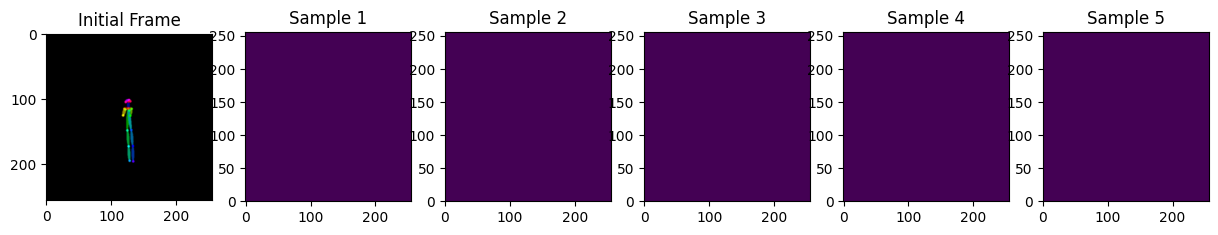

In [55]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

# Function to denormalize images
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # Denormalize from [-1, 1] to [0, 1]
    return tensor

# Dataset definition for inference
class SpectrogramNPYDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.npy_files = [f for f in os.listdir(folder_path) if '_spectrogram' in f]
        self.transform = transform  # Assign the transform function
        

        # Define the transformation for resizing
        self.resize_transform = transforms.Resize((256, 256))

        # Load initial frame
        self.initial_frame = self.load_initial_frame()

    def load_initial_frame(self):
        frame_files = [f for f in os.listdir(self.folder_path) if '_frame' in f]
        if len(frame_files) == 0:
            raise FileNotFoundError("No initial frame found in the folder.")
        frame_path = os.path.join(self.folder_path, frame_files[0])
        frame = np.load(frame_path)
        frame = torch.from_numpy(frame.astype(np.float32)).permute(2, 0, 1)
        frame = torch.tensor(frame, dtype=torch.float32)
        frame = self.resize_transform(frame)  # Resize the frame to 256x256
        frame = (frame / 127.5) - 1  # Normalize to [-1, 1]
        
        return frame

    def __len__(self):
        return len(self.npy_files)
    
    def __getitem__(self, idx):
        npy_name = os.path.join(self.folder_path, self.npy_files[idx])
        spectrogram = np.load(npy_name)

        # Ensure it has the channel dimension
        spectrogram = torch.from_numpy(spectrogram.astype(np.float32)).unsqueeze(0)  # Add channel dimension
        
        spectrogram = transform(spectrogram)

        spectrogram = torch.tensor(spectrogram, dtype=torch.float32)

        # Normalize to [-1, 1]
        spectrogram = (spectrogram / 127.5) - 1

        
        
        return spectrogram, self.initial_frame

# Define the transformation

transform = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),  # p=1.0 ensures the flip always happens
])

# Create the dataset and dataloader for inference
folder_path = 'C:/Users/David/Documents/postgrau/Projecte/raining/frames/Inference Spectrograms'
inference_dataset = SpectrogramNPYDataset(folder_path, transform=transform)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False)

# Visualize a few spectrograms and the initial frame
def visualize_spectrograms(dataset, num_samples=5):
    plt.figure(figsize=(15, 2.2))
    
    # Plot initial frame
    initial_frame = dataset.initial_frame.permute(1, 2, 0).numpy()
    initial_frame = (initial_frame + 1) * 127.5  # Denormalize
    plt.subplot(1, num_samples + 1, 1)
    plt.imshow(initial_frame.astype(np.uint8))
    plt.title('Initial Frame')

    for i in range(num_samples):
        spectrogram, _ = dataset[i]
        spectrogram = spectrogram.squeeze().numpy()
        plt.subplot(1, num_samples + 1, i + 2)
        plt.imshow(spectrogram, aspect='auto', origin='lower')
        plt.title(f'Sample {i+1}')
    
    plt.show()

visualize_spectrograms(inference_dataset, num_samples=5)


C:\Users\David\AppData\Local\Temp\ipykernel_11204\2421006847.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrogram = torch.tensor(spectrogram, dtype=torch.float32)


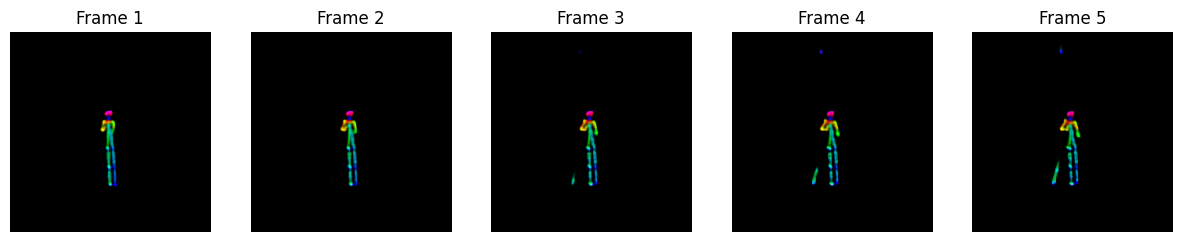

In [56]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import torch.nn.functional as F
import os

# Ensure consistent normalization/denormalization functions
def denormalize(tensor):
    return tensor * 0.5 + 0.5  # Assuming normalization to [-1, 1] range during training

netG.train()  # Set the model to training mode

# Move model to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
netG.to(device)

# Create a directory to save individual frames if it doesn't exist
os.makedirs('results/individual_frames', exist_ok=True)

# Perform inference and save the generated frames
with torch.no_grad():
    # Load the initial frame
    fake_frame = inference_dataset.initial_frame.to(device).unsqueeze(0)

    # Process each batch in the inference loader
    for batch_idx, (spectrograms, initial_frame) in enumerate(inference_loader):
        spectrograms = spectrograms.to(device)  # Move spectrograms to the correct device

        # Initialize the previous frame with the initial frame
        previous_frame = fake_frame

        # Initialize hidden state for ConvLSTM
        hidden_state = None

        # Process each spectrogram in the batch
        for i, spectrogram in enumerate(spectrograms):
            # Generate fake frame
            fake_frame, hidden_state = netG(torch.cat((spectrogram.unsqueeze(0), previous_frame), dim=1), hidden_state)
            fake_frame_denorm = denormalize(fake_frame)  # Denormalize the generated frame

            # Save the generated frame
            save_image(fake_frame_denorm.squeeze(), f'results/individual_frames/frame_{batch_idx * inference_loader.batch_size + i + 1}.png')

            # Update the previous frame for the next iteration
            previous_frame = fake_frame

# Visualize the first few results
def visualize_generated_frames(folder_path, num_samples=5):
    plt.figure(figsize=(15, 2.7))
    for i in range(num_samples):
        frame_path = os.path.join(folder_path, f'frame_{i + 1}.png')
        frame = plt.imread(frame_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(frame)
        plt.title(f'Frame {i + 1}')
        plt.axis('off')
    plt.show()

visualize_generated_frames('results/individual_frames', num_samples=5)
        

Make video

In [57]:
%pip install opencv-python

import os
import cv2

# Directory containing the frames
frames_dir = 'results/individual_frames'

# Path to save the video
video_path = 'results/output_video_V10_5.mp4'

# Frames per second
fps = 30

# Get the list of all frame files and sort them numerically
frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.png')],
                     key=lambda x: int(x.split('_')[1].split('.')[0]))

# Read the first frame to get the dimensions
first_frame = cv2.imread(os.path.join(frames_dir, frame_files[0]))
height, width, layers = first_frame.shape

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

# Write each frame to the video
for frame_file in frame_files:
    frame_path = os.path.join(frames_dir, frame_file)
    frame = cv2.imread(frame_path)
    video.write(frame)

# Release the VideoWriter object
video.release()

print(f'Video saved at {video_path}')


Note: you may need to restart the kernel to use updated packages.
Video saved at results/output_video_V10_5.mp4
